In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_and_play(audio_path):
    """Load audio file and return audio data with sampling rate"""
    print("Loading audio file...")
    y, sr = librosa.load(audio_path)
    print(f"Audio loaded: {len(y)/sr:.2f} seconds, {sr}Hz sampling rate")
    
    # Play first 10 seconds
    display(Audio(data=y[:sr*10], rate=sr, autoplay=False))
    return y, sr

# Replace with your audio file path
audio_path = "infer3.mp3"
y_original, sr = load_and_play(audio_path)

Loading audio file...
Audio loaded: 25.28 seconds, 22050Hz sampling rate


In [10]:
def separate_vocals(audio_data, sr):
    """Separate vocals from instrumental audio"""
    print("Separating vocals from instrumental...")
    
    # Compute spectrogram magnitude and phase
    S_full, phase = librosa.magphase(librosa.stft(audio_data))
    
    # Apply Non-negative Matrix Factorization filter
    S_filter = librosa.decompose.nn_filter(
        S_full,
        aggregate=np.median,
        metric='cosine',
        width=int(librosa.time_to_frames(2, sr=sr))
    )
    
    # Ensure filtered output doesn't exceed input
    S_filter = np.minimum(S_full, S_filter)
    
    # Apply soft-masking
    margin_i, margin_v = 1, 10
    power = 1
    
    # Create masks for instrumental and vocal
    mask_i = librosa.util.softmask(
        S_filter,
        margin_i * (S_full - S_filter),
        power=power
    )
    
    mask_v = librosa.util.softmask(
        S_full - S_filter,
        margin_v * S_filter,
        power=power
    )
    
    # Apply masks
    S_background = mask_i * S_full
    S_foreground = mask_v * S_full
    
    # Reconstruct audio
    y_background = librosa.istft(S_background * phase)
    y_foreground = librosa.istft(S_foreground * phase)
    
    return y_background, y_foreground, S_full, S_background, S_foreground


In [11]:
y_instrumental, y_vocals, S_full, S_background, S_foreground = separate_vocals(y_original, sr)


Separating vocals from instrumental...


In [12]:
print("Original Audio (first 10 seconds):")
display(Audio(data=y_original[:sr*10], rate=sr))

print("\nInstrumental Track (first 10 seconds):")
display(Audio(data=y_instrumental[:sr*10], rate=sr))

print("\nVocal Track (first 10 seconds):")
display(Audio(data=y_vocals[:sr*10], rate=sr))


Original Audio (first 10 seconds):



Instrumental Track (first 10 seconds):



Vocal Track (first 10 seconds):


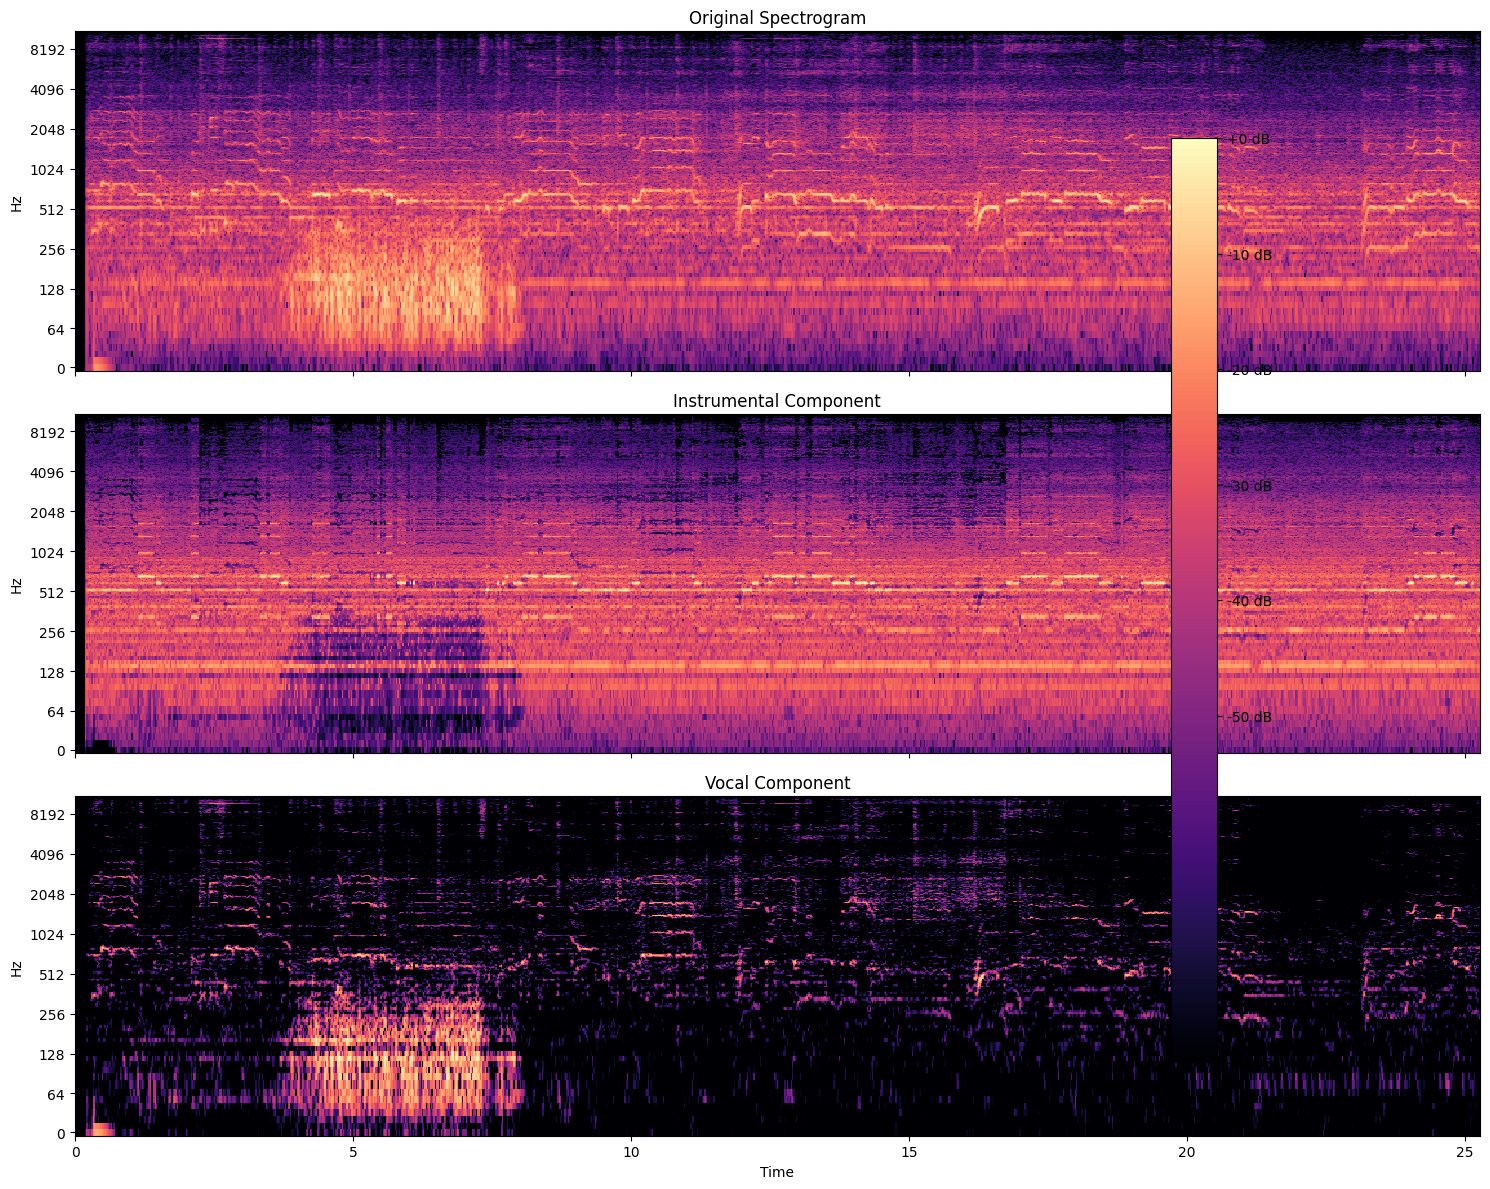

In [6]:
def plot_spectrograms(S_full, S_background, S_foreground, sr):
    """Plot the spectrograms of original, instrumental, and vocal components"""
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)
    
    # Plot full spectrogram
    img = librosa.display.specshow(
        librosa.amplitude_to_db(S_full, ref=np.max),
        y_axis='log', x_axis='time',
        sr=sr, ax=axes[0]
    )
    axes[0].set_title('Original Spectrogram')
    axes[0].label_outer()
    
    # Plot instrumental spectrogram
    librosa.display.specshow(
        librosa.amplitude_to_db(S_background, ref=np.max),
        y_axis='log', x_axis='time',
        sr=sr, ax=axes[1]
    )
    axes[1].set_title('Instrumental Component')
    axes[1].label_outer()
    
    # Plot vocal spectrogram
    librosa.display.specshow(
        librosa.amplitude_to_db(S_foreground, ref=np.max),
        y_axis='log', x_axis='time',
        sr=sr, ax=axes[2]
    )
    axes[2].set_title('Vocal Component')
    
    # Add colorbar
    fig.colorbar(img, ax=axes, format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Plot the spectrograms
plot_spectrograms(S_full, S_background, S_foreground, sr)